# Calibrating SDEs
In this notebook, we show how the collision-based dynamics can be used to calibrate SDEs given data. First we import some libraries.

In [36]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
sys.path.append(src_path)
from collision import collOT_pytorch as collOT
import torch
from torch import nn, optim

rng = np.random.seed(0)
size = 7;
cm = 0.393701; #inches
markers = ["o", "s", "<", ">", "d", "+"]

# Geometric Brownian Motion
As an example, let us consider data generated by n-dimensioal random variable $X$ that follows a SDE of the form

$dX_{t,i} = M_{ij}(X_{t,j}) dt + X_{t,i}\sigma_{ij}(dW_{t,j})$

We consider $i,j=1,...,n$ where $n=5$, and draw a random matrices for $M, \sigma \in \mathbb{R}^{n\times n}$ as a model to generate data. Here, $dW_t\sim \mathcal{N}(0,\Delta t)$ denotes incerements of standard $n$-dimensional Wiener process. We generate $N_p=10^4$ samples by solving this SDE using Euler-Maruyama scheme with $N_t=100$ steps and $\Delta t=5\times10^{-4}$.

In [37]:
def sigma(x, sigma0):
  return  np.matmul(sigma0,x)

def mu(x, mu0):
  return  np.matmul(mu0,x)

Np = 10000 # number of samples per variable
N = 5 # number of r.v. dim(X)
Nt = 100 # number of steps, number of marginals
dt = 5e-4 # time step size

def forward(Xt, mu0, sigma0, t, dt):
    # dim X = (N,Np)
    dW = (2*dt)**0.5 * np.random.normal(0, 1, Xt.shape)
    return Xt + mu(Xt, mu0) * dt + Xt*sigma(dW, sigma0)

def generate_data(Np, N = 10, Nt = 100, dt = 0.01, X0 = None, m=0, sd=1, **kwargs):
  mu0 = kwargs.get('mu0')
  sigma0 = kwargs.get('sigma0')

  if X0 is None:
      X = np.random.normal(m,sd,(Nt,N,Np))
  else:
    X = np.zeros((Nt,N,Np))
    X[0,:] = X0.T.copy()
  for i in range(0, Nt-1):
      t = i*dt
      X[i+1,...] = forward(X[i,...], mu0, sigma0, t, dt)
  X = np.swapaxes(X,1,2) # Nt, Np, N
  return X

#generate data
np.random.seed(0)

D_mu = np.diag(np.sort(np.random.uniform(-10,10, N)))
Q, _ = np.linalg.qr(np.random.normal(0,1,(N,N)))
mu0 = Q @ D_mu @np.linalg.inv(Q)

eig, vec = np.linalg.eig( mu0 )
print("eig(D_mu)", np.diag(D_mu))
print("eig(mu0)", np.sort(eig))

D_sigma = np.diag(np.sort(np.random.uniform(0.1,2, N)))
Q, _ = np.linalg.qr(np.random.normal(0,1,(N,N)))
sigma0 = Q @ D_sigma @np.linalg.inv(Q)

eig, vec = np.linalg.eig( sigma0 )
print("eig(D_sigma)", np.diag(D_sigma))
print("eig(sigma0)", np.sort(eig))


variables_dict = {
    'mu0': mu0,
    'sigma0': sigma0
}

m1 = np.random.uniform(1,20,N)
m2 = np.random.uniform(1,20,N)
s1 = np.random.uniform(0.1,2,N)
s2 = np.random.uniform(0.1,2,N)

X0 = np.zeros((Np,N))
for i in range(N):
    X0[:,i] = np.concatenate([np.random.normal(m1[i],s1[i],(int(Np/2))), np.random.normal(m2[i],s2[i],(Np- int(Np/2)))],axis=0)
X = generate_data(Np=Np, N=N, Nt=Nt, dt = dt, X0=X0, **variables_dict)

X00 = X.copy()
print(X.shape)



eig(D_mu) [-1.52690401  0.89766366  0.97627008  2.05526752  4.30378733]
eig(mu0) [-1.52690401  0.89766366  0.97627008  2.05526752  4.30378733]
eig(D_sigma) [0.2144284  0.78306501 0.93036071 1.39545857 1.42549927]
eig(sigma0) [0.2144284  0.78306501 0.93036071 1.39545857 1.42549927]
(100, 10000, 5)


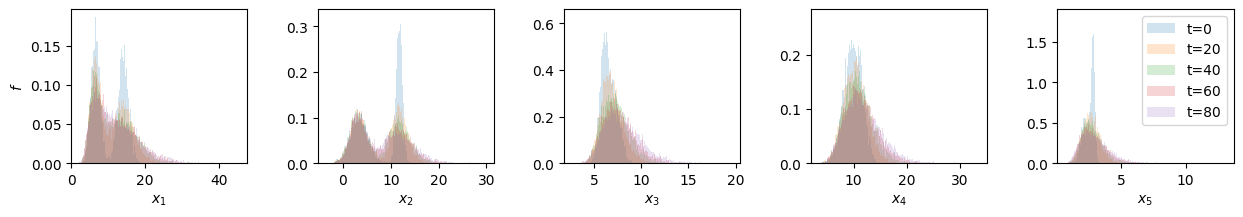

In [38]:
fig, axes = plt.subplots(1, N, figsize=(N*3, 2))

for j in range(N):
    _ = [axes[j].hist(X[20*i,:,j], bins=200, alpha=0.2, density=True, label="t="+str(20*i)) for i in range(5)]
    axes[j].set_xlabel(r"$x_"+str(j+1)+"$")
axes[0].set_ylabel(r"$f$")
axes[-1].legend()
fig.subplots_adjust(wspace=0.4, hspace=0.4)

## Calibration SDE using Collisional-OT
Now that we have generated the dataset, we attempt to calibrate the SDE. Here, we use the PyTorch implementation of the collision-based dynamics to estimate the optimal map between outcome of simulation of the guessed SDE and the data at the final time $t=T$. This allows us to estimate Wasserstein distance in a tractable/differentiable way, and update the parameters of SDE in a gradient descent step.

Since we are interested in calibration of SDE, and not its discovery, we assume that we know the form of the SDE and only the parameters are unknown. 

In [39]:
class SDE_Estimator(nn.Module):
    def __init__(self, N=5, hidden_layer=10):
        super().__init__()
        self.mu = nn.Linear(N, N, bias=False)
        self.sigma = nn.Linear(N, N, bias=False)

        nn.init.zeros_(self.mu.weight)
        nn.init.zeros_(self.sigma.weight)

    def forward(self, x: torch.Tensor, dt):
      dW = (2*dt)**0.5 * torch.randn_like(x)
      return x + self.mu(x)*dt + x*self.sigma(dW)

    def loss(self, x: torch.Tensor, y: torch.Tensor, tol=1e-6, MinIter=1000, MaxIter=1000):
        x, y, hist = collOT(x, y, tol=tol, MinIter=MinIter, MaxIter=MaxIter)
        return torch.mean( torch.sum((x - y) ** 2, axis=-1) )

n_epochs = 50
sde_estimator = SDE_Estimator(N=N)
optimizerStat = optim.Adam(sde_estimator.parameters(), lr=0.1)
losses_stat = []
Xstat_final = []
Xtensor = torch.tensor(X00.copy(), dtype=torch.float32)

for epoch in range(0, n_epochs+1):
  lossStat = 0
  Xstat = Xtensor[0,...].clone()
  optimizerStat.zero_grad()
  for i in range(0, Nt-1):
      t = i*dt
      Xstat = sde_estimator.forward(Xstat, dt)
  Xstat_final.append(Xstat.detach())

  lossStat += sde_estimator.loss( Xtensor[-1,...], Xstat, MinIter=10000, MaxIter=10000 )
  lossStat.backward()
  optimizerStat.step()

  if epoch % 1 == 0:
      print(f"epoch {epoch}, stat Loss: {lossStat.item()}")

  losses_stat.append(lossStat.item())

epoch 0, stat Loss: 44.346920013427734
epoch 1, stat Loss: 37.27260208129883
epoch 2, stat Loss: 29.710649490356445
epoch 3, stat Loss: 21.425479888916016
epoch 4, stat Loss: 15.653665542602539
epoch 5, stat Loss: 11.809208869934082
epoch 6, stat Loss: 10.32497787475586
epoch 7, stat Loss: 10.827310562133789
epoch 8, stat Loss: 12.096357345581055
epoch 9, stat Loss: 12.182809829711914
epoch 10, stat Loss: 10.078810691833496
epoch 11, stat Loss: 8.994354248046875
epoch 12, stat Loss: 6.692490577697754
epoch 13, stat Loss: 6.167423248291016
epoch 14, stat Loss: 5.481940746307373
epoch 15, stat Loss: 5.711513042449951
epoch 16, stat Loss: 6.014472484588623
epoch 17, stat Loss: 6.537463188171387
epoch 18, stat Loss: 6.570281982421875
epoch 19, stat Loss: 6.720081806182861
epoch 20, stat Loss: 6.140870094299316
epoch 21, stat Loss: 5.738541126251221
epoch 22, stat Loss: 5.283214569091797
epoch 23, stat Loss: 4.999281883239746
epoch 24, stat Loss: 4.719245433807373
epoch 25, stat Loss: 4.710

## Error in the training dataset
Here, we check how the distribution the estimated SDE at final time has changed during training (this is for sanity check).

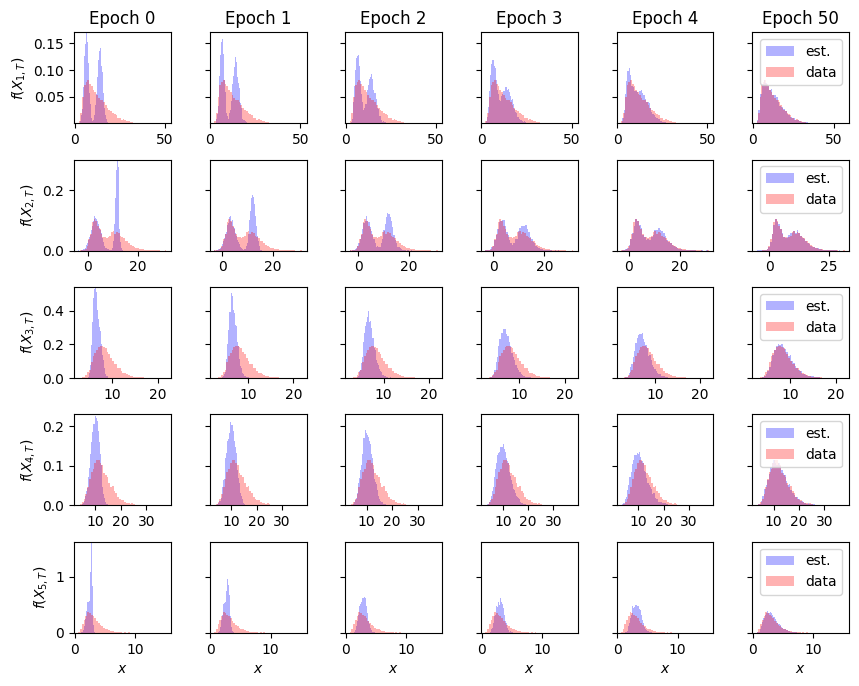

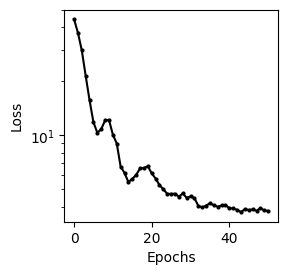

In [40]:
Xstat_final = np.array(Xstat_final)

nepochs = 6 #Xstat_final.shape[0]
fig, axs = plt.subplots(N, nepochs, figsize=(2*N, 1.3*nepochs))
fig.subplots_adjust(hspace=0.4)
for k in range(N):
  for j in range(nepochs):
    if j == nepochs-1:
        ep = Xstat_final.shape[0]-1
    else:
        ep = j*1
    s = axs[k, j].hist(Xstat_final[ep,:,k],bins=50,alpha=0.3,density=True, color="blue", label="est.")
    _ = axs[k, j].hist(X00[-1,:,k],bins=50,alpha=0.3,density=True, color="red", label="data")

    if j == 0:
        s0 = s[0].copy()
    axs[k, j].set_ylim([np.min(s0), np.max(s0)])

    if k == 0:
        axs[k, j].set_title("Epoch " + str(ep))
    if k == N-1:
        axs[k, j].set_xlabel(r"$x$")
    if j == 0:
        axs[k, j].set_ylabel(r"$f(X_{" + str(k+1) + ",T})$")
    else:
        axs[k, j].set_yticklabels([])
        axs[k, j].set_ylim()
    if j == nepochs-1:
        axs[k, j].legend()

fig.subplots_adjust(wspace=0.4, hspace=0.4)
#fig.savefig("Calibrate_train_GBM.pdf", format='pdf', dpi=300, bbox_inches='tight')

fig, ax = plt.subplots();
ax.plot( losses_stat, color="black", marker="o", markersize=2)
ax.set_ylabel(r"Loss")
ax.set_xlabel(r"Epochs")
#ax.set_xscale("log")
ax.set_yscale("log")

fig.set_size_inches(size*cm, size*cm)
#plt.savefig('Loss_Calibrate_train_GBM.pdf',format='pdf', bbox_inches="tight", dpi=300);

## Error in testing/validation dataset
Having calibrated the SDE to the data, now we can test/validate the model. We generate new samples by simulating the original SDE with a different intial condition and compare the transition of solution against the output of calibrated SDE.

In [45]:
m1 = np.random.uniform(1,20,N)
m2 = np.random.uniform(1,20,N)
s1 = np.random.uniform(0.1,2,N)
s2 = np.random.uniform(0.1,2,N)
Nt = 201

X0 = np.zeros((Np,N))
for i in range(N):
    X0[:,i] = np.concatenate([np.random.normal(m1[i],s1[i],(int(Np/2))), np.random.normal(m2[i],s2[i],(Np- int(Np/2)))],axis=0)
Xnew = generate_data(Np=Np, N=N, Nt=Nt, dt = dt, X0=X0, **variables_dict)

Xnewhat = torch.tensor(Xnew, dtype=torch.float32).clone()
for i in range(0, Nt-1):
      Xnewhat[i+1,...] = sde_estimator.forward(Xnewhat[i,...], dt)

Xnewhat = Xnewhat.detach().numpy()

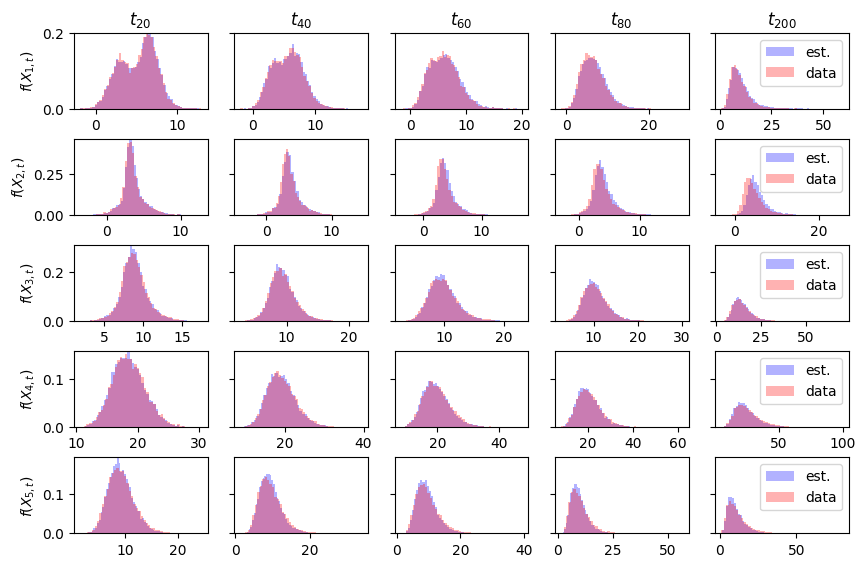

In [46]:
nt = 5
fig, axs = plt.subplots(N, nt, figsize=(2*N, 1.3*nt))
fig.subplots_adjust(hspace=0.4)
for k in range(N):
  for j in range(nt):
    if j == nt-1:
        ep = Xnewhat.shape[0]-1
    else:
        ep = (j+1)*20
    s = axs[k, j].hist(Xnewhat[ep,:,k],bins=50,alpha=0.3,density=True, color="blue", label="est.")
    _ = axs[k, j].hist(Xnew[ep,:,k],bins=50,alpha=0.3,density=True, color="red", label="data")

    if j == 0:
        s0 = s[0].copy()
    axs[k, j].set_ylim([np.min(s0), np.max(s0)])

    if k == 0:
        axs[k, j].set_title(r"$t_{" + str(ep)+"}$")
    #if k == N-1:
    #    axs[k, j].set_xlabel(r"$x$")
    if j == 0:
        axs[k, j].set_ylabel(r"$f(X_{" + str(k+1) + ",t})$")
    else:
        axs[k, j].set_yticklabels([])
        axs[k, j].set_ylim()
    if j == nt-1:
        axs[k, j].legend()

#fig.savefig("Calibrate_test_GBM.pdf", format='pdf', dpi=300, bbox_inches='tight')